In [4]:
%load_ext autoreload
%autoreload 2

# Make sure the project root is in Python path
import sys, os
project_root = os.path.abspath("..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [5]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.table import Table
import matplotlib as mpl
from scipy.ndimage import shift
from src.analysis_module import gaussian_weight, wiener_deconvolution
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from scipy.spatial import cKDTree
import pandas as pd

In [ ]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['axes.edgecolor'] = 'none'
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['xtick.labelbottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['ytick.labelleft'] = False
mpl.rcParams['axes.grid'] = False

Filename: ../data/EuclidRubinData/53.0_-28.0/u_53.00_-28.00.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  IMAGE         1 ImageHDU        35   (3400, 3400)   float32   
  2  MASK          1 ImageHDU        52   (3400, 3400)   int32   
  3  VARIANCE      1 ImageHDU        35   (3400, 3400)   float32   
  4  ARCHIVE_INDEX    1 BinTableHDU     41   6600R x 7C   [1J, 1J, 1J, 1J, 1J, 64A, 64A]   
  5  FilterLabel    1 BinTableHDU     28   1R x 3C   [2X, 32A, 32A]   
  6  SkyWcs        1 BinTableHDU     17   132R x 1C   [1QB(15541)]   
  7  CoaddInputs    1 BinTableHDU     81   37R x 16C   [1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1K, 1J, 1J, 1J, 1J, 1J, 1D, 32A]   
  8  PhotoCalib    1 BinTableHDU     36   131R x 5C   [1X, 1D, 1D, 1J, 1J]   
  9  ChebyshevBoundedField    1 BinTableHDU     41   3152R x 6C   [1J, 1J, 1J, 1J, 1J, 1D]   
 10  CoaddInputs    2 BinTableHDU     90   93R x 18C   [1J, 1J, 1J, 1J, 1J, 1J, 1J, 1J, 1K,

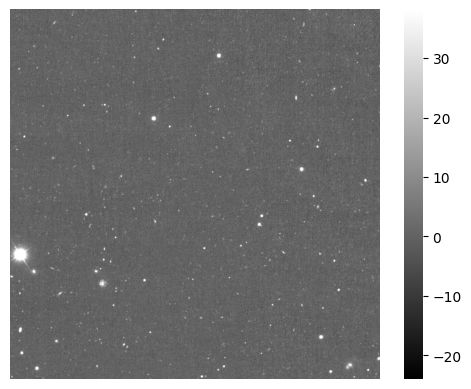

In [70]:
# Open the FITS file
hdul = fits.open('../data/EuclidRubinData/53.0_-28.0/u_53.00_-28.00.fits')
hdul.info()  # Lists HDUs (Header/Data Units) in the file
header = hdul[0].header

for key, value in header.items():
    print(f"{key:10} : {value}")
# Usually the image data is in the first HDU
image_data = hdul[1].data

zscale = ZScaleInterval()
vmin, vmax = zscale.get_limits(image_data)
norm = ImageNormalize(vmin=vmin, vmax=vmax)

# Close the FITS file
hdul.close()

# Simple plot
plt.imshow(image_data, cmap='gray', origin='lower', norm=norm)
plt.colorbar()
plt.show()

In [77]:
# Read .cat file (ignores lines starting with #)
catalog = Table.read('../data/EuclidRubinData/53.0_-28.0/z.cat', format='ascii')

# Show first few rows
print(type(catalog['X_IMAGE', 'Y_IMAGE']))

# Access columns

<class 'astropy.table.table.Table'>


In [6]:
# for i, (x, y) in enumerate(catalog['X_IMAGE', 'Y_IMAGE']):
#     plt.scatter(x, y, c='cyan', marker='+', s=2)
#     if i % 1000 == 0 and (i >0):
#         print(i, '/', len(catalog['X_IMAGE', 'Y_IMAGE']))
#         # break
# plt.imshow(image_data)
# plt.show()

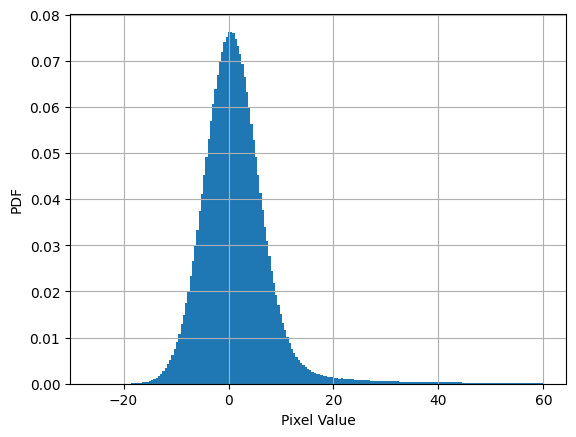

In [7]:
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    plt.hist(image_data[image_data<60].flatten(), bins=200, density=True)
    plt.xlabel('Pixel Value')
    plt.ylabel('PDF')
    plt.show()

In [8]:
from scipy.stats import invgamma, norm

x = image_data[image_data<0].flatten()

n = len(x)
S = np.sum(x**2)

# Posterior for tau = sigma^2 is Inv-Gamma(a=n/2, scale=beta=S/2)
a = n / 2.0
beta = S / 2.0

# scipy's invgamma uses 'a' (shape) and 'scale' parameters
post_tau = invgamma(a=a, scale=beta)

# draw samples to summarize sigma posterior
nsamp = 20000
tau_samps = post_tau.rvs(size=nsamp)
sigma_samps = np.sqrt(tau_samps)

# point estimates
sigma_map = np.sqrt(beta / (a + 1))            # mode of tau -> sqrt(mode)
sigma_mean = sigma_samps.mean()                # posterior mean (via sampling)
sigma_median = np.median(sigma_samps)

# credible interval (2.5%, 97.5%)
ci_low, ci_high = np.percentile(sigma_samps, [2.5, 97.5])

print(f"MAP (approx) sigma = {sigma_map:.4f}")
print(f"Posterior mean sigma = {sigma_mean:.4f}")
print(f"Posterior median sigma = {sigma_median:.4f}")
print(f"95% credible interval for sigma = [{ci_low:.4f}, {ci_high:.4f}]")

MAP (approx) sigma = 4.7889
Posterior mean sigma = 4.7888
Posterior median sigma = 4.7889
95% credible interval for sigma = [4.7858, 4.7918]


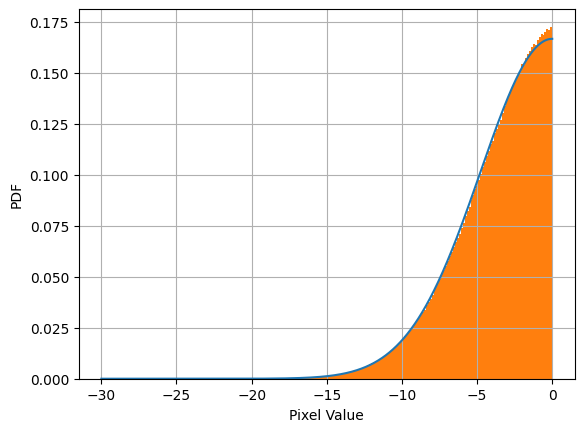

In [9]:
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    plt.plot(np.linspace(-30, 0, 1000), norm.pdf(np.linspace(-30, 0, 1000), 0, sigma_mean)*2)
    plt.hist(image_data[image_data<0].flatten(), bins=200, density=True)
    plt.xlabel('Pixel Value')
    plt.ylabel('PDF')
    plt.show()

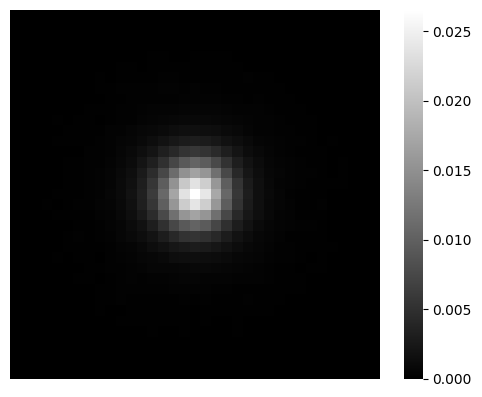

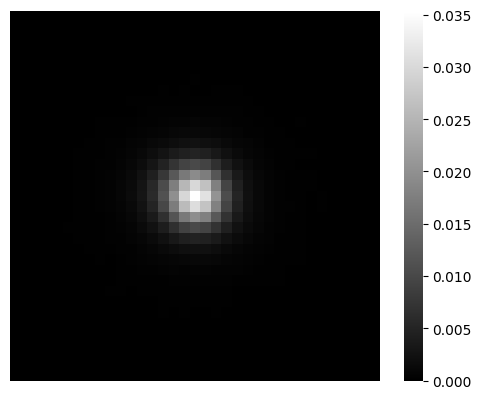

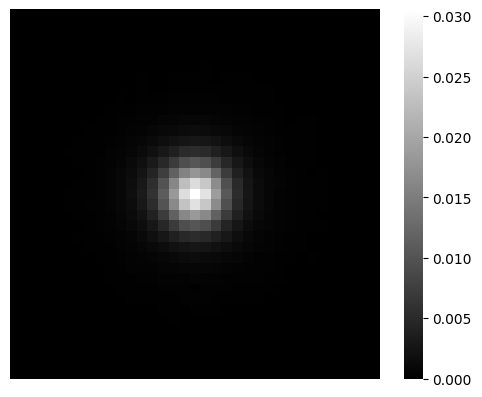

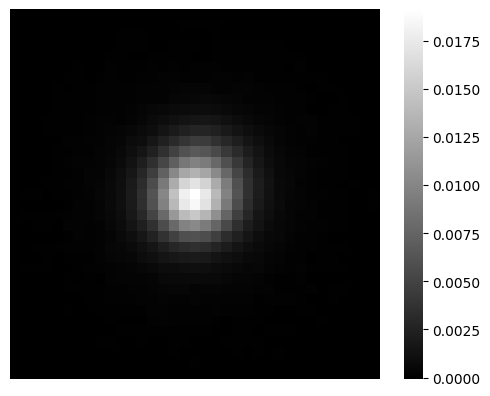

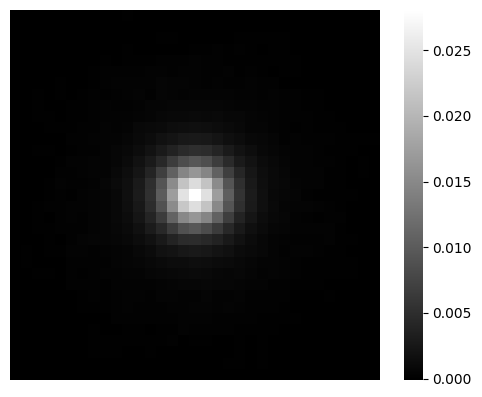

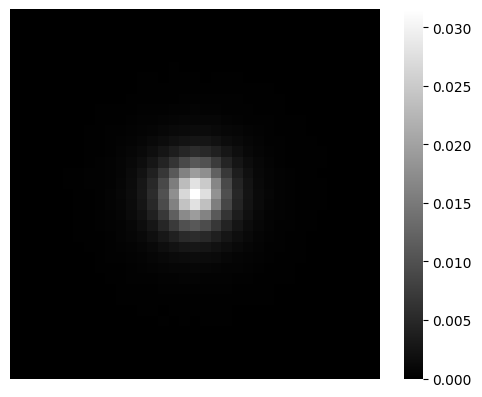

In [ ]:
filters = ['g', 'i', 'r', 'u', 'y', 'z']
for fil in filters:
    # Open the FITS file
    hdul = fits.open(f'../data/EuclidRubinData/53.0_-28.0/{fil}_53.00_-28.00.psf.fits')
    psf = hdul[0].data

    # zscale = ZScaleInterval()
    # vmin, vmax = zscale.get_limits(image_data)
    # norm = ImageNormalize(vmin=vmin, vmax=vmax)

    # Close the FITS file
    hdul.close()

    # Simple plot
    plt.imshow(psf)
    plt.colorbar()
    plt.show()


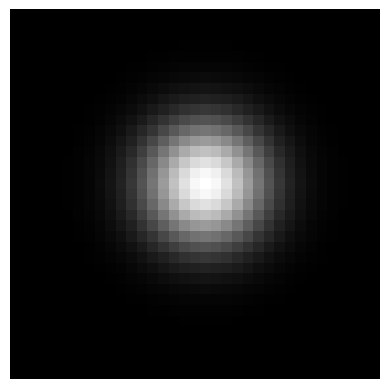

In [11]:
weight = gaussian_weight(image_data.shape[0], image_data.shape[1], image_data.shape[0]/2, image_data.shape[1]/2, 4, 4)
hB, wB = psf.shape[:2]
hA, wA = weight.shape[:2]

# Compute crop start points to center the crop
start_x = max((wA - wB) // 2, 0)
start_y = max((hA - hB) // 2, 0)

# Crop Image A
croppedA = weight[start_y:start_y + hB, start_x:start_x + wB]
plt.imshow(croppedA)
plt.show()

In [40]:
w_flat = rescaled_weight.flatten()
w_sorted = np.sort(w_flat)[::-1]
cumsum = np.cumsum(w_sorted)
threshold = w_sorted[np.searchsorted(cumsum, 0.99)]
print(threshold)

0.0011814229323563953


In [ ]:
def shift_and_sum(points):
    dy, dx = points

    # np.roll rolls along each axis
    translated = np.roll(rescaled_weight, shift=(dy, dx), axis=(0, 1))
    return np.sum(translated[translated > threshold] * image_data[translated > threshold])

rescaled_weight = wiener_deconvolution(weight, psf, 0)
cy, cx = np.array(rescaled_weight.shape) / 2
data = [[yc - cy, xc - cx] for (xc, yc) in catalog['X_IMAGE', 'Y_IMAGE']]

In [55]:
from multiprocessing.dummy import Pool  # thread-based
from tqdm import tqdm

with Pool() as pool:
    results = list(tqdm(pool.imap(shift_and_sum, data), total=len(data)))

100%|██████████| 5509/5509 [03:41<00:00, 24.87it/s]


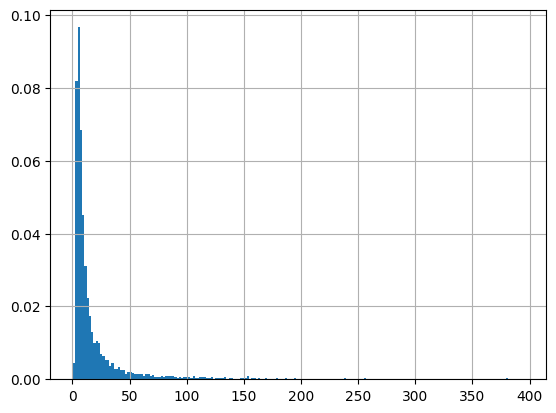

In [59]:
results = np.array(results)
with plt.rc_context({
    'xtick.bottom': True,
    'xtick.labelbottom': True,
    'ytick.left': True,
    'ytick.labelleft': True,
    'axes.edgecolor': 'black',
    'axes.grid': True
}):
    plt.hist(results[results<400], bins=200, density=True)
    plt.show()

In [47]:
print(np.mean(results), np.std(results))

-0.30199312867465994 5.551115123125783e-17


In [ ]:
for fil in ['u', 'g', 'r']:
    catalog = Table.read(f'../data/EuclidRubinData/53.0_-28.0/{fil}.cat', format='ascii')
    
    hdul = fits.open(f'../data/EuclidRubinData/53.0_-28.0/{fil}_53.00_-28.00.fits')
    image_data = hdul[1].data
    hdul.close()
    weight = gaussian_weight(image_data.shape[0], image_data.shape[1], image_data.shape[0]/2, image_data.shape[1]/2, 4, 4)
    hdul = fits.open(f'../data/EuclidRubinData/53.0_-28.0/{fil}_53.00_-28.00.psf.fits')
    psf = hdul[0].data
    hdul.close()

    data = {'x': np.array(catalog['X_IMAGE']), 'y': np.array(catalog['Y_IMAGE'])}

    rescaled_weight = wiener_deconvolution(weight, psf, 0)
    cy, cx = np.array(rescaled_weight.shape) / 2
    shifts = [[yc - cy, xc - cx] for (xc, yc) in catalog['X_IMAGE', 'Y_IMAGE']]
    with Pool() as pool:
        result = list(tqdm(pool.imap(shift_and_sum, shifts), total=len(shifts)))
    data['flux'] = result
    if fil == 'u':
        u_df = pd.DataFrame(data)
    elif fil == 'g':
        g_df = pd.DataFrame(data)
    elif fil == 'r':
        r_df = pd.DataFrame(data)
    

  0%|          | 0/1227 [00:00<?, ?it/s]

In [7]:
from multiprocessing.dummy import Pool

In [8]:
def shift_and_sum(points):
    dy, dx = points

    # np.roll rolls along each axis
    translated = np.roll(rescaled_weight, shift=(dy, dx), axis=(0, 1))
    return np.sum(translated * image_data)

In [11]:
fil = 'r'
catalog = Table.read(f'../data/EuclidRubinData/53.0_-28.0/{fil}.cat', format='ascii')
    
hdul = fits.open(f'../data/EuclidRubinData/53.0_-28.0/{fil}_53.00_-28.00.fits')
image_data = hdul[1].data
hdul.close()
weight = gaussian_weight(image_data.shape[0], image_data.shape[1], image_data.shape[0]/2, image_data.shape[1]/2, 4, 4)
hdul = fits.open(f'../data/EuclidRubinData/53.0_-28.0/{fil}_53.00_-28.00.psf.fits')
psf = hdul[0].data
hdul.close()

data = {'x': np.array(catalog['X_IMAGE']), 'y': np.array(catalog['Y_IMAGE'])}

rescaled_weight = wiener_deconvolution(weight, psf, 0)
print('Weight calculated')
cy, cx = np.array(rescaled_weight.shape) / 2
shifts = [[yc - cy, xc - cx] for (xc, yc) in catalog['X_IMAGE', 'Y_IMAGE']]
with Pool() as pool:
    result = list(tqdm(pool.imap(shift_and_sum, shifts), total=len(shifts)))
data['flux'] = result
r_df = pd.DataFrame(data)

Weight calculated


100%|██████████| 9739/9739 [08:42<00:00, 18.62it/s]


In [12]:
import numpy as np
from scipy.spatial import cKDTree

def align_fluxes_by_reference(dfs, max_dist=2.0):
    """
    Align multiple catalogs by coordinates using the smallest catalog as reference.

    Parameters
    ----------
    dfs : dict
        {filter_name: pandas.DataFrame} each with columns ['x','y','flux']
    max_dist : float
        Maximum distance (pixels) for matching

    Returns
    -------
    bands : list
        Filter names in the same order as columns
    flux_matrix : ndarray
        Shape (N_ref, N_bands), fluxes aligned by reference coordinates
    """
    # Find reference catalog (smallest)
    ref_band = min(dfs, key=lambda k: len(dfs[k]))
    ref_df = dfs[ref_band]
    x_ref = ref_df['x'].values
    y_ref = ref_df['y'].values
    ref_points = np.column_stack((x_ref, y_ref))

    bands = list(dfs.keys())
    flux_list = []

    for band in bands:
        df = dfs[band]
        x = df['x'].values
        y = df['y'].values
        points = np.column_stack((x, y))

        # Build KDTree and query nearest neighbor for each reference point
        tree = cKDTree(points)
        dist, idx = tree.query(ref_points, distance_upper_bound=max_dist)

        # Initialize flux array with NaNs
        flux_aligned = np.full(len(ref_points), np.nan)

        # Fill only valid matches
        valid = idx < len(df)
        flux_aligned[valid] = df['flux'].values[idx[valid]]

        flux_list.append(flux_aligned)

    # Combine into 2D array: rows = galaxies, columns = filters
    flux_matrix = np.column_stack(flux_list)
    return bands, flux_matrix

dfs = {
    'u': u_df,
    'g': g_df,
    'r': r_df
}

bands, flux_matrix = align_fluxes_by_reference(dfs, max_dist=2.0)

print("Bands:", bands)
print("Flux matrix shape:", flux_matrix.shape)

Bands: ['u', 'g', 'r']
Flux matrix shape: (1227, 3)


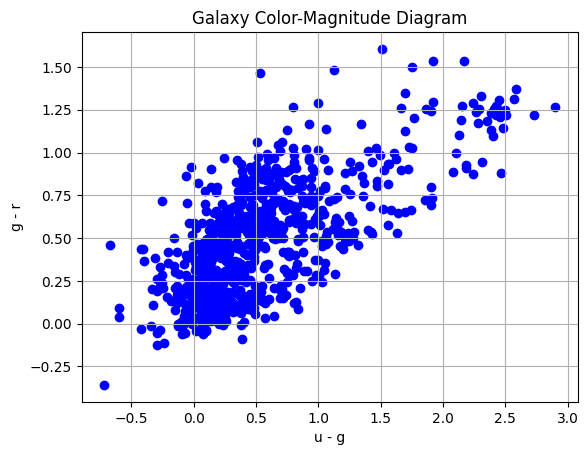

In [19]:
for (u_flux, g_flux, r_flux) in flux_matrix:
    plt.scatter(-2.5 * np.log10(u_flux/g_flux), -2.5 * np.log10(g_flux/r_flux), c='b')
plt.title('Galaxy Color-Magnitude Diagram')
plt.grid(True)
plt.xlabel('u - g')
plt.ylabel('g - r')
plt.savefig('../results/figures/first_color_magnitude.pdf')
plt.show()
